<a href="https://colab.research.google.com/github/Hachimboua/Gridworld-environment/blob/main/RL_zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get -qq install swig cmake ffmpeg > /dev/null
!pip install -q "rl_zoo3[plots]" "gymnasium[classic-control]" "imageio[ffmpeg]" "stable-baselines3"

import os
import gymnasium as gym
from stable_baselines3 import PPO
import imageio
from IPython.display import Video, display


env = gym.make("CartPole-v1", render_mode="rgb_array")

model_path = "best_model_cartpole.zip"


if not os.path.exists(model_path):
    print("⚙️ Training a new PPO model...")
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=50_000)
    model.save(model_path)
    print("✅ Model saved as:", model_path)
else:
    print("📂 Loading existing model:", model_path)
    model = PPO.load(model_path, env=env)


frames = []
obs, _ = env.reset()
for _ in range(500):
    frame = env.render()
    frames.append(frame)
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        obs, _ = env.reset()

video_path = "cartpole.mp4"
imageio.mimsave(video_path, frames, fps=30)
env.close()

display(Video(video_path, embed=True))


⚙️ Training a new PPO model...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.8     |
|    ep_rew_mean     | 24.8     |
| time/              |          |
|    fps             | 641      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.4        |
|    ep_rew_mean          | 29.4        |
| time/                   |             |
|    fps                  | 543         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008694008 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.00985     |
|    learning_rate        | 0.

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# **PART 2**

In [ ]:
# Cell 1: environment definition
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random

# probabilities for stochastic motion
P_MAIN = 0.8
P_SIDE = 0.1

class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"]}

    def __init__(self,
                 size=5,
                 goals=[(4, 4)],
                 obstacles=None,
                 max_steps=50,
                 dynamic_elements=False,
                 obstacle_penalty=-5.0,
                 step_penalty=-1.0,
                 goal_reward=1.0,
                 cell_size=80):   # cell_size used for rendering
        super().__init__()
        self.size = size
        self.goals = list(goals)
        self.obstacle_penalty = obstacle_penalty
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.max_steps = max_steps
        self.dynamic_elements = dynamic_elements

        if obstacles is None:
            obstacles = []
        self.obstacles = list(obstacles)

        # Actions: 0=Up, 1=Down, 2=Left, 3=Right (matches your original)
        self.action_space = spaces.Discrete(4)

        # Observation: the (row,col) of the agent as two ints -> use Box of floats
        # Keep values in [0, size-1]; the network expects floats
        self.observation_space = spaces.Box(low=0.0, high=float(self.size-1),
                                            shape=(2,), dtype=np.float32)

        self.cell_size = cell_size
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = [0, 0]
        self.steps = 0
        obs = np.array(self.agent_pos, dtype=np.float32)
        return obs, {}

    def get_state(self):
        return tuple(self.agent_pos)

    def _get_next_pos(self, x, y, action):
        # reproducing your original movement constraints
        if action == 0 and x > 0: x -= 1
        elif action == 1 and x < self.size - 1: x += 1
        elif action == 2 and y > 0: y -= 1
        elif action == 3 and y < self.size - 1: y += 1
        return [x, y]

    def _move_dynamic_elements(self):
        if self.dynamic_elements:
            self.goals = [(
                random.randint(0, self.size - 1),
                random.randint(0, self.size - 1)
            ) for _ in self.goals]
            self.obstacles = [(
                random.randint(0, self.size - 1),
                random.randint(0, self.size - 1)
            ) for _ in self.obstacles]

    def step(self, action):
        x, y = self.agent_pos
        # keep your original side-drift choice logic but ensure probabilities sum to 1
        # For Up/Down: side moves are Left and Right (2 and 3)
        # For Left/Right: side moves are Up and Down (0 and 1)
        if action in [0, 1]:
            move_choices = [action, 2, 3]
        else:
            move_choices = [action, 0, 1]

        effective_action = np.random.choice(move_choices, p=[P_MAIN, P_SIDE, P_SIDE])
        new_pos = self._get_next_pos(x, y, effective_action)

        # default reward is step penalty unless obstacle or goal
        reward = self.step_penalty
        if tuple(new_pos) in self.obstacles:
            reward = self.obstacle_penalty
            # agent does not move into obstacle in your previous code
        else:
            self.agent_pos = new_pos

        self.steps += 1
        self._move_dynamic_elements()

        done = False
        if tuple(self.agent_pos) in self.goals:
            reward = self.goal_reward
            done = True

        if self.steps >= self.max_steps:
            done = True

        obs = np.array(self.agent_pos, dtype=np.float32)
        # Gymnasium step returns (obs, reward, terminated, truncated, info)
        # We treat 'done' as terminated and set truncated False (change if you want time-truncation)
        terminated = done
        truncated = False
        info = {}
        return obs, float(reward), terminated, truncated, info

    def render(self, mode="rgb_array"):
        # create a colored grid (white background), obstacles black, goals green, agent red
        grid = np.ones((self.size, self.size, 3), dtype=np.float32)  # white
        for ox, oy in self.obstacles:
            grid[ox, oy] = [0.0, 0.0, 0.0]  # black
        for gx, gy in self.goals:
            grid[gx, gy] = [0.0, 1.0, 0.0]  # green
        ax, ay = self.agent_pos
        grid[ax, ay] = [1.0, 0.0, 0.0]      # red

        # enlarge cells so the GIF is visible
        frame = np.kron(grid, np.ones((self.cell_size, self.cell_size, 1)))
        # return uint8 RGB array 0..255
        return (frame * 255).astype(np.uint8)

    def close(self):
        pass


In [ ]:
# Cell 2: training snippet
!pip install -q stable-baselines3[extra]  # run this in Colab once

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# create env factory for DummyVecEnv
def make_env():
    return GridWorldEnv(size=5,
                        goals=[(4,4)],
                        obstacles=[(2,2)],
                        max_steps=50,
                        dynamic_elements=False,
                        obstacle_penalty=-5.0,
                        step_penalty=-1.0,
                        goal_reward=10.0,
                        cell_size=40)
env = DummyVecEnv([make_env])

model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-4,
    buffer_size=10000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    tau=1.0,
    target_update_interval=500,
    exploration_fraction=0.2,
    exploration_final_eps=0.02,
    verbose=1,
)

# train - start with a modest amount and increase if needed
model.learn(total_timesteps=30000)

# Evaluate on separate env instance (deterministic eval)
eval_env = GridWorldEnv(size=5, goals=[(4,4)], obstacles=[(2,2)], goal_reward=10.0)
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20, deterministic=True)
print("Eval:", mean_reward, std_reward)


Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7950     |
|    time_elapsed     | 0        |
|    total_timesteps  | 163      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8508     |
|    time_elapsed     | 0        |
|    total_timesteps  | 349      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 7819     |
|    time_elapsed     | 0        |
|    total_timesteps  | 549      |
----------------------------------
----------------------------------
| 


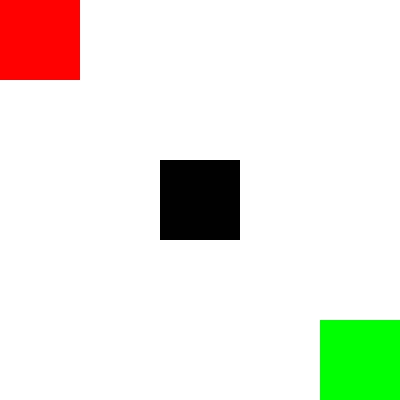

In [ ]:
# Cell 3: record frames and save gif
import imageio.v2 as imageio
from IPython.display import HTML
from base64 import b64encode

eval_env = GridWorldEnv(size=5, goals=[(4,4)], obstacles=[(2,2)], goal_reward=10.0, cell_size=80)
obs, _ = eval_env.reset()
frames = []
for step in range(50):
    frame = eval_env.render()
    frames.append(frame)
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(int(action))
    if terminated or truncated:

        frames.append(eval_env.render())
        break

# Save GIF
gif_path = "gridworld_agent.gif"
imageio.mimsave(gif_path, frames, fps=3)

# display inline at a larger width
with open(gif_path,'rb') as f:
    data = b64encode(f.read()).decode('utf-8')
HTML(f'<img src="data:image/gif;base64,{data}" width="480">')


In [ ]:
!pip install -q stable-baselines3[extra] gymnasium


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Environment factory
def make_env():
    return GridWorldEnv(
        size=5,
        goals=[(4,4)],
        obstacles=[(2,2)],
        max_steps=50,
        dynamic_elements=False,
        obstacle_penalty=-5.0,
        step_penalty=-1.0,
        goal_reward=10.0,
        cell_size=40
    )

env = DummyVecEnv([make_env])


In [ ]:
model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=3e-4,
    n_steps=128,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    verbose=1,
)

model.learn(total_timesteps=100_000)


Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 140          |
|    total_timesteps      | 64640        |
| train/                  |              |
|    approx_kl            | 0.0010583433 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.154       |
|    explained_variance   | 0.624        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.46         |
|    n_updates            | 5040         |
|    policy_gradient_loss | -0.00267     |
|    value_loss           | 5.91         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 461          |
|    iterations           | 506          |
|    time_elapsed         | 140          |
|    total_timesteps      | 64768        |
| train/                  |              |
|    approx_kl            | 3.072014e-05 |
|  

In [ ]:
eval_env = GridWorldEnv(
    size=5,
    goals=[(4,4)],
    obstacles=[(2,2)],
    goal_reward=10.0,
    cell_size=60
)

mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20, deterministic=True)
print(f"PPO Evaluation — Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")


PPO Evaluation — Mean reward: 0.20 ± 3.87



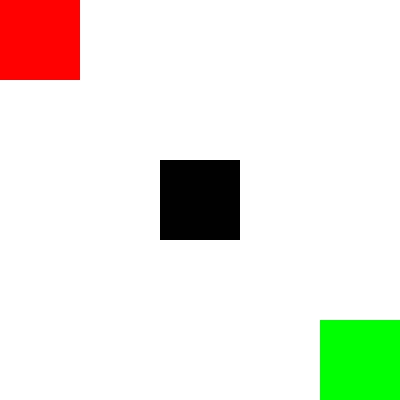

In [ ]:
import imageio.v2 as imageio
from IPython.display import HTML
from base64 import b64encode

eval_env = GridWorldEnv(size=5, goals=[(4,4)], obstacles=[(2,2)], goal_reward=10.0, cell_size=80)
obs, _ = eval_env.reset()
frames = []

for step in range(50):
    frame = eval_env.render()
    frames.append(frame)
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(int(action))
    if terminated or truncated:
        frames.append(eval_env.render())
        break

gif_path = "ppo_gridworld.gif"
imageio.mimsave(gif_path, frames, fps=3)

with open(gif_path,'rb') as f:
    data = b64encode(f.read()).decode('utf-8')
HTML(f'<img src="data:image/gif;base64,{data}" width="480">')
